In [1]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO
import cv2
import random
import os.path as osp
import matplotlib.pyplot as plt

## Load submission files

In [2]:
# ensemble csv files
submission_files = [
    '/opt/ml/ensemble/submission_jina_swinl_fold0_aug.csv',
    '/opt/ml/ensemble/submission_ksh_cascade_convnext_fold3.csv',
    '/opt/ml/ensemble/submission_ksh_swinb_fold0.csv',
    '/opt/ml/ensemble/submission_rch_swinl_fold3_aug.csv',
    '/opt/ml/ensemble/dragon_ensemble.csv',
    '/opt/ml/ensemble/ksh_convnext.csv'
]

submission_df = [pd.read_csv(file) for file in submission_files]
org_submission_df = [pd.read_csv(file) for file in submission_files] # Save original for visualization

image_ids = submission_df[0]['image_id'].tolist()

# ensemble 할 file의 image 정보를 불러오기 위한 json
annotation = '../detection/dataset/test.json'
coco = COCO(annotation)

# For visualization later
individual_model_bbox_colors = [(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for _ in range(len(submission_df))]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Config Settings

In [13]:
# Data Directory
DATA_DIR = '/opt/ml/detection/dataset'

# PRE / POST Processing Confidence Threshold - Set 0.0 not to use them.
PRE_CONFIDENCE_THRESHOLD = 0.08
POST_CONFIDENCE_THRESHOLD = 0.08

# Choose only ONE for now
USE_NMS_ENSEMBLE = False
USE_SOFT_NMS_ENSEMBLE = False
USE_WBF_ENSEMBLE = True

assert sum([USE_NMS_ENSEMBLE, USE_SOFT_NMS_ENSEMBLE, USE_WBF_ENSEMBLE]) == 1, "Choose only ONE ensemble method for now!"

# NMS Config
NMS_IOU_THRESHOLD = 0.55

# SOFT-NMS Config
SOFT_NMS_IOU_THRESHOLD = 0.55
SOFT_NMS_SIGMA=0.3
SOFT_NMS_THRESHOLD=1e-4

# WBF Config
WBF_IOU_THRESHOLD=0.55
WBF_SKIP_BOX_THRESHOLD=0.1

# Final Submission Save Path
USE_SUBMIT = False
FINAL_SUBMISSION_SAVE_PATH = '/opt/ml/ensemble/submission_ensemble_wbf_0.55.csv'

## Preprocessing - Remove Low confidence-score bboxes

In [14]:
for df_idx, df in enumerate(submission_df):
    for idx in range(len(df)):
        pred_str = df.iloc[idx]['PredictionString']
        if str(pred_str) == 'nan':
            continue 
        bboxes = np.array(pred_str.strip().split()).reshape(-1, 6)

        bboxes = [bbox for bbox in bboxes if float(bbox[1]) > PRE_CONFIDENCE_THRESHOLD] # Only leave bboxes whose confidence > threshold
        new_pred_str = ' '.join(np.array(bboxes).reshape(-1)) + ' '
        df.loc[idx, 'PredictionString'] = new_pred_str

## Ensemble

In [15]:
prediction_strings = []
file_names = []

# 각 image id 별로 submission file에서 box좌표 추출
for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    
#     각 submission file 별로 prediction box좌표 불러오기
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))

    # 예측 box가 있다면 이를 ensemble 수행
    if len(boxes_list):
        
        # Perform Ensemble
        if USE_NMS_ENSEMBLE:
            boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=NMS_IOU_THRESHOLD)
        if USE_SOFT_NMS_ENSEMBLE:
            boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, iou_thr=SOFT_NMS_IOU_THRESHOLD, sigma=SOFT_NMS_SIGMA, thresh=SOFT_NMS_THRESHOLD)
        if USE_WBF_ENSEMBLE:
            boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=WBF_IOU_THRESHOLD, skip_box_thr=WBF_SKIP_BOX_THRESHOLD)
        
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    
    file_names.append(image_id)

## Construct submission csv

In [6]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.head()

,PredictionString,image_id
0,7 0.9998829960823059 604.3358154296875 518.986...,test/0000.jpg
1,5 0.9939409494400024 133.3480682373047 0.57713...,test/0001.jpg
2,1 0.986098051071167 424.3096618652344 268.6226...,test/0002.jpg
3,9 0.999623715877533 154.11199951171875 262.108...,test/0003.jpg
4,1 0.9806605577468872 202.15895080566406 265.37...,test/0004.jpg


## Num. bboxes for ensembled model before Postprocessing - 1st Image

In [7]:
print("[Number of bboxes of ensembled model for 1st test image before ]: {}".format(len(np.array(submission.iloc[0]['PredictionString'].strip().split()).reshape(-1, 6))))

[Number of bboxes of ensembled model for 1st test image before ]: 69


## Postprocessing - Remove ensembled low-confidence bboxes

In [8]:
for idx in range(len(submission)):
    pred_str = submission.iloc[idx]['PredictionString']
    bboxes = np.array(pred_str.strip().split()).reshape(-1, 6)
    
    bboxes = [bbox for bbox in bboxes if float(bbox[1]) > POST_CONFIDENCE_THRESHOLD]
    new_pred_str = ' '.join(np.array(bboxes).reshape(-1)) + ' '
    submission.loc[idx, 'PredictionString'] = new_pred_str

## Num. bboxes for ensembled model After Postprocessing - 1st Image

In [9]:
print("[Number of bboxes of ensembled model for 1st test image After ]: {}".format(len(np.array(submission.iloc[0]['PredictionString'].strip().split()).reshape(-1, 6))))

[Number of bboxes of ensembled model for 1st test image After ]: 46


## Save Final ensemble csv file

In [10]:
if USE_SUBMIT:
    submission.to_csv(FINAL_SUBMISSION_SAVE_PATH)

## Ensemble Visualization

In [11]:
############# Visualization Config ################

TEST_IMG_ID = 27 # 테스트하고 싶은 이미지 번호 (0~4870)

ENABLE_INDIVIDUAL_MODEL_INDICES = [] # Try different combinations with model indices (현재 파일 맨위에 csv파일 인덱스), 안보고싶으면 []으로 set
ENABLE_ENSEMBLE = True # Ensemble모델 visualization
ENSEMBLE_BBOX_COLOR_RGB = (235, 195, 0)
FIG_SIZE = (1, 20)

--------------------- BBox count for Final Ensemble Model ----------------------
[Final Ensemble]: 10
--------------------------------------------------------------------------------


------------------------ BBox count for Original Models ------------------------
[submission_jina_swinl_fold0_aug.csv]: 11
[submission_ksh_cascade_convnext_fold3.csv]: 100
[submission_ksh_swinb_fold0.csv]: 100
[submission_rch_swinl_fold3_aug.csv]: 9

[Total bbox count for ALL original models]: 220
--------------------------------------------------------------------------------



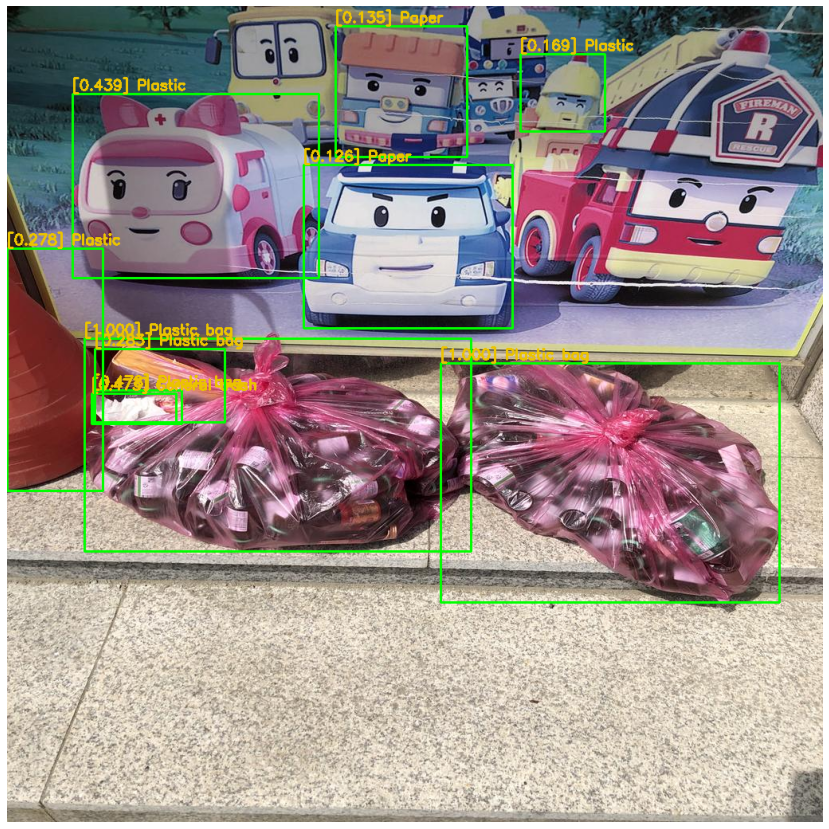

In [12]:
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

img_id = submission.iloc[TEST_IMG_ID]['image_id']
img_arr = cv2.imread(osp.join(DATA_DIR, img_id))
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

boxes_list = []

total_ensemble_boxes_cnt = 0
total_individual_model_cnt = 0

for df in org_submission_df:
    pred_str = df.iloc[TEST_IMG_ID]['PredictionString']
    pred_bboxes = np.array(pred_str.strip().split()).reshape(-1, 6)
    boxes_list.append(pred_bboxes)

# Visualization for Individual Models
for model_idx, boxes_per_model in enumerate(boxes_list):
    if model_idx not in ENABLE_INDIVIDUAL_MODEL_INDICES:
        continue
    
    for idx, bbox in enumerate(boxes_per_model):
        total_individual_model_cnt += 1
        label, score, xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))

        caption = classes[int(label)] + score

        cv2.rectangle(img_arr, (xmin, ymin), (xmax, ymax), color=individual_model_bbox_colors[model_idx], thickness=2)
        cv2.putText(img_arr, caption, (xmin, ymin-5), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.6, color=(253, 241, 115), thickness=1)


# Visualization for Final Ensembled Model
ensemble_boxes = np.array(submission.iloc[TEST_IMG_ID]['PredictionString'].strip().split()).reshape(-1, 6)

if ENABLE_ENSEMBLE:
    for idx, bbox in enumerate(ensemble_boxes):
        total_ensemble_boxes_cnt += 1
        label, score, xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))

        caption = str(f"[{float(score):.3f}]") + " " + str(classes[int(label)])

        cv2.rectangle(img_arr, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)
        cv2.putText(img_arr, caption, (xmin, ymin-5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6, color=ENSEMBLE_BBOX_COLOR_RGB, thickness=2)
 
##
############# Bbox count for Final Ensemble model #################
if ENABLE_ENSEMBLE:
    print("-"*21 + " BBox count for Final Ensemble Model " + "-"*22)
    print("[Final Ensemble]: {}".format(total_ensemble_boxes_cnt))
    print("-"*80)
    print("\n")


############# Bbox count for Selected Individual models #################
if len(ENABLE_INDIVIDUAL_MODEL_INDICES):
    print("-"*18 + " BBox count for Selected Individual Models " + "-"*19)
    print("[Model Indices {}]: {}".format(ENABLE_INDIVIDUAL_MODEL_INDICES, total_individual_model_cnt))
    print("-"*80)
    print("\n")

############# Bbox count for ORIGINAL models #################
print("-"*24 + " BBox count for Original Models " + "-"*24)
org_df_bbox_cnt = [len(np.array(df.iloc[TEST_IMG_ID]['PredictionString'].strip().split()).reshape(-1, 6)) for df in org_submission_df]

for idx, df_fname in enumerate(submission_files):
    model_name = df_fname.split('/')[-1]
    model_bbox_cnt = org_df_bbox_cnt[idx]
    print("[{}]: {}".format(model_name, model_bbox_cnt))

print("")
print("[Total bbox count for ALL original models]: {}".format(sum(org_df_bbox_cnt)))
print("-"*80)

# Plot Predictions
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(img_arr)
print("")